# Identifying Ethnicity in OpenSAFELY-TPP
This short report describes how ethnicity can be identified in the OpenSAFELY-TPP database, and the strengths and weaknesses of the methods. This is a living document that will be updated to reflect changes to the OpenSAFELY-TPP database and the patient records within.

## OpenSAFELY
OpenSAFELY is an analytics platform for conducting analyses on Electronic Health Records inside the secure environment where the records are held. This has multiple benefits: 

* We don't transport large volumes of potentially disclosive pseudonymised patient data outside of the secure environments for analysis
* Analyses can run in near real-time as records are ready for analysis as soon as they appear in the secure environment
* All infrastructure and analysis code is stored in GitHub repositories, which are open for security review, scientific review, and re-use

A key feature of OpenSAFELY is the use of study definitions, which are formal specifications of the datasets to be generated from the OpenSAFELY database. This takes care of much of the complex EHR data wrangling required to create a dataset in an analysis-ready format. It also creates a library of standardised and validated variable definitions that can be deployed consistently across multiple projects. 

The purpose of this report is to describe all such variables that relate to BMI, their relative strengths and weaknesses, in what scenarios they are best deployed. It will also describe potential future definitions that have not yet been implemented.

## Available Records
OpenSAFELY-TPP runs inside TPP’s data centre which contains the primary care records for all patients registered at practices using TPP’s SystmOne Clinical Information System. This data centre also imports external datasets from other sources, including A&E attendances and hospital admissions from NHS Digital’s Secondary Use Service, and death registrations from the ONS. More information on available data sources can be found within the OpenSAFELY documentation. 

In [253]:
import os
import pandas as pd
import numpy as np
from itertools import product
from IPython.display import display, Markdown, Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None 
pd.options.display.float_format = '{:,.0f}'.format

In [254]:

def local_patient_counts(
    definitions, output_path, code_dict="", categories=False, missing=False,
):
    import pandas as pd

    suffix = "_filled"
    overlap = "all_filled"
    if missing == True:
        suffix = "_missing"
        overlap = "all_missing"
    if categories:
        df_append = pd.read_csv(
            f"../output/{output_path}/simple_patient_counts_categories.csv"
        ).set_index(["group", "subgroup"])
        # ensure definitions[n] in code_dict[definitions[n]] below refers to one of the definitions of interest
        definitions = [
            f"{category}_{definition}"
            for category, definition in product(
                code_dict[definitions[1]].values(), definitions
            )
        ]
    else:
        df_append = pd.read_csv(
            f"../output/{output_path}/simple_patient_counts.csv"
        ).set_index(["group", "subgroup"])

    for definition in definitions:
        if missing:
            df_append[definition + suffix] = (
                df_append["population"] - df_append[definition + "_filled"]
            )
        df_append[definition + "_pct"] = round(
            (df_append[definition + suffix].div(df_append["population"])) * 100, 1
        )
        df_append[overlap + "_pct"] = round(
            (df_append[overlap].div(df_append["population"])) * 100, 1
        )

        # Combine count and percentage columns
        df_append[definition] = (
            df_append[definition + suffix].apply(lambda x: "{:,.0f}".format(x))
            + " ("
            + df_append[definition + "_pct"].astype(str)
            + ")"
        )
        df_append = df_append.drop(columns=[definition + suffix, definition + "_pct"])
    df_append[overlap] = (
        df_append[overlap].apply(lambda x: "{:,.0f}".format(x))
        + " ("
        + df_append[overlap + "_pct"].astype(str)
        + ")"
    )
    df_append = df_append.drop(columns=[overlap + "_pct"])
    df_patient_counts = df_append[definitions + [overlap] + ["population"]]
    # Final redaction step
    df_patient_counts = df_patient_counts.replace(np.nan, "-")
    df_patient_counts = df_patient_counts.replace("nan (nan)", "- (-)")
    df_patient_counts.columns = df_patient_counts.columns.str.replace("_", " ")
    display(df_patient_counts)


In [255]:
### CONFIGURE ###
definitions = ['ethnicity_5', 'ethnicity_new_5', 'ethnicity_primis_5']
covariates = ['_age_band','_sex','_region','_imd','_dementia','_diabetes','_hypertension','_learning_disability']
output_path = 'released'

code_dict = {
    "imd": {
        0: "Unknown",
        1: "1 Most deprived",
        2: "2",
        3: "3",
        4: "4",
        5: "5 Least deprived",
    },
    "ethnicity_5": {1: "White", 2: "Mixed", 3: "Asian", 4: "Black", 5: "Other"},
    "ethnicity_new_5": {1: "White", 2: "Mixed", 3: "Asian", 4: "Black", 5: "Other"},
    "ethnicity_primis_5": {1: "White", 2: "Mixed", 3: "Asian", 4: "Black", 5: "Other"},
}



## Results

### Count of Patients

In [256]:
local_patient_counts(
         definitions,  output_path
    )

ethnicity 5  \
group               subgroup                                      
all                 with records              18,790,805 (75.9)   
age_band            0-19                       3,381,570 (62.2)   
                    20-29                      2,199,015 (71.5)   
                    30-39                      2,894,890 (81.4)   
                    40-49                      2,633,005 (82.6)   
                    50-59                      2,751,205 (81.1)   
                    60-69                      2,204,255 (81.6)   
                    70-79                      1,777,240 (82.0)   
                    80+                          949,620 (76.8)   
                    missing                               - (-)   
sex                 F                          9,588,050 (77.6)   
                    M                          9,202,755 (74.2)   
region              East                       4,354,510 (75.6)   
                    East Midlands              3,262,875 (76.6)   
                    London                     1,436,215 (80.0)   
                    North East                   888,240 (76.1)   
                    North West                 1,621,780 (76.0)   
                    South East                 1,216,550 (74.0)   
                    South West                 2,481,280 (73.0)   
                    West Midlands                811,275 (80.2)   
                    Yorkshire and The Humber   2,688,860 (75.7)   
imd                 1 Most deprived            3,767,715 (76.7)   
                    2                          3,685,435 (76.3)   
                    3                          3,905,945 (76.6)   
                    4                          3,624,320 (75.7)   
                    5 Least deprived           3,278,295 (75.0)   
                    Unknown                      529,095 (69.7)   
dementia            False                     18,755,940 (75.9)   
                    True                          34,870 (80.2)   
diabetes            False                     16,839,640 (75.1)   
                    True                       1,951,165 (83.1)   
hypertension        False                     17,267,100 (75.3)   
                    True                       1,523,705 (83.0)   
learning_disability False                     18,674,915 (75.9)   
                    True                         115,890 (82.3)   

                                                ethnicity new 5  \
group               subgroup                                      
all                 with records              18,530,915 (74.8)   
age_band            0-19                       3,334,345 (61.3)   
                    20-29                      2,167,945 (70.5)   
                    30-39                      2,849,200 (80.1)   
                    40-49                      2,590,355 (81.2)   
                    50-59                      2,714,830 (80.0)   
                    60-69                      2,178,125 (80.6)   
                    70-79                      1,757,045 (81.1)   
                    80+                          939,070 (76.0)   
                    missing                               - (-)   
sex                 F                          9,456,460 (76.5)   
                    M                          9,074,455 (73.2)   
region              East                       4,294,100 (74.6)   
                    East Midlands              3,208,865 (75.3)   
                    London                     1,409,285 (78.5)   
                    North East                   881,040 (75.5)   
                    North West                 1,603,115 (75.1)   
                    South East                 1,199,055 (72.9)   
                    South West                 2,454,175 (72.2)   
                    West Midlands                794,275 (78.6)   
                    Yorkshire and The Humber   2,658,015 (74.8)   
imd                 1 Most depr

### Count of Missings

In [257]:
local_patient_counts(
         definitions,  output_path, missing= True
    )

ethnicity 5  \
group               subgroup                                     
all                 with records              5,968,405 (24.1)   
age_band            0-19                      2,058,800 (37.8)   
                    20-29                       876,470 (28.5)   
                    30-39                       661,200 (18.6)   
                    40-49                       556,530 (17.4)   
                    50-59                       641,885 (18.9)   
                    60-69                       496,490 (18.4)   
                    70-79                       390,265 (18.0)   
                    80+                         286,765 (23.2)   
                    missing                              - (-)   
sex                 F                         2,770,855 (22.4)   
                    M                         3,197,550 (25.8)   
region              East                      1,404,025 (24.4)   
                    East Midlands               997,475 (23.4)   
                    London                      358,115 (20.0)   
                    North East                  278,200 (23.9)   
                    North West                  512,745 (24.0)   
                    South East                  427,240 (26.0)   
                    South West                  918,245 (27.0)   
                    West Midlands               199,685 (19.8)   
                    Yorkshire and The Humber    863,650 (24.3)   
imd                 1 Most deprived           1,144,455 (23.3)   
                    2                         1,141,750 (23.7)   
                    3                         1,195,130 (23.4)   
                    4                         1,162,205 (24.3)   
                    5 Least deprived          1,094,650 (25.0)   
                    Unknown                     230,215 (30.3)   
dementia            False                     5,959,775 (24.1)   
                    True                          8,625 (19.8)   
diabetes            False                     5,571,590 (24.9)   
                    True                        396,820 (16.9)   
hypertension        False                     5,656,400 (24.7)   
                    True                        312,005 (17.0)   
learning_disability False                     5,943,515 (24.1)   
                    True                         24,890 (17.7)   

                                               ethnicity new 5  \
group               subgroup                                     
all                 with records              6,228,295 (25.2)   
age_band            0-19                      2,106,025 (38.7)   
                    20-29                       907,540 (29.5)   
                    30-39                       706,890 (19.9)   
                    40-49                       599,180 (18.8)   
                    50-59                       678,260 (20.0)   
                    60-69                       522,620 (19.4)   
                    70-79                       410,460 (18.9)   
                    80+                         297,315 (24.0)   
                    missing                              - (-)   
sex                 F                         2,902,445 (23.5)   
                    M                         3,325,850 (26.8)   
region              East                      1,464,435 (25.4)   
                    East Midlands             1,051,485 (24.7)   
                    London                      385,045 (21.5)   
                    North East                  285,400 (24.5)   
                    North West                  531,410 (24.9)   
                    South East                  444,735 (27.1)   
                    South West                  945,350 (27.8)   
                    West Midlands               216,685 (21.4)   
                    Yorkshire and The Humber    894,495 (25.2)   
imd                 1 Most deprived           1,205,565 (24.5)   
                    2   

### Count by Category

In [282]:
local_patient_counts(
         definitions,  output_path,code_dict, categories=True,missing=False
    )

White ethnicity 5  \
group               subgroup                                      
all                 with records              15,688,375 (63.4)   
age_band            0-19                       2,641,455 (48.6)   
                    20-29                      1,688,385 (54.9)   
                    30-39                      2,265,530 (63.7)   
                    40-49                      2,088,765 (65.5)   
                    50-59                      2,407,755 (71.0)   
                    60-69                      2,007,925 (74.3)   
                    70-79                      1,686,405 (77.8)   
                    80+                          902,150 (73.0)   
                    missing                               - (-)   
sex                 F                          8,066,950 (65.3)   
                    M                          7,621,425 (61.5)   
region              East                       3,727,865 (64.7)   
                    East Midlands              2,723,075 (63.9)   
                    London                       756,705 (42.2)   
                    North East                   786,490 (67.4)   
                    North West                 1,499,990 (70.3)   
                    South East                 1,079,900 (65.7)   
                    South West                 2,320,400 (68.3)   
                    West Midlands                522,795 (51.7)   
                    Yorkshire and The Humber   2,247,105 (63.3)   
imd                 1 Most deprived            2,777,390 (56.5)   
                    2                          2,901,255 (60.1)   
                    3                          3,339,005 (65.5)   
                    4                          3,237,445 (67.6)   
                    5 Least deprived           2,997,850 (68.6)   
                    Unknown                      435,435 (57.3)   
dementia            False                     15,655,750 (63.3)   
                    True                          32,630 (75.0)   
diabetes            False                     14,136,400 (63.1)   
                    True                       1,551,975 (66.1)   
hypertension        False                     14,298,795 (62.4)   
                    True                       1,389,580 (75.7)   
learning_disability False                     15,586,390 (63.3)   
                    True                         101,985 (72.4)   

                                             White ethnicity new 5  \
group               subgroup                                         
all                 with records                 15,527,840 (62.7)   
age_band            0-19                          2,616,335 (48.1)   
                    20-29                         1,672,960 (54.4)   
                    30-39                         2,242,170 (63.1)   
                    40-49                         2,064,985 (64.7)   
                    50-59                         2,382,075 (70.2)   
                    60-69                         1,987,505 (73.6)   
                    70-79                         1,668,940 (77.0)   
                    80+                             892,870 (72.2)   
                    missing                                  - (-)   
sex                 F                             7,983,705 (64.6)   
                    M                             7,544,135 (60.8)   
region              East                          3,690,895 (64.1)   
                    East Midlands                 2,684,890 (63.0)   
                    London                          748,675 (41.7)   
                    North East                      782,280 (67.1)   
                    North West                    1,485,595 (69.6)   
                    South East                    1,068,405 (65.0)   
                    South West                    2,300,960 (67.7)   
                    West Midlands                   514,440 (50.9)   
                    Yorksh

### Overlapping Definitions
Idea: Use an upset plot

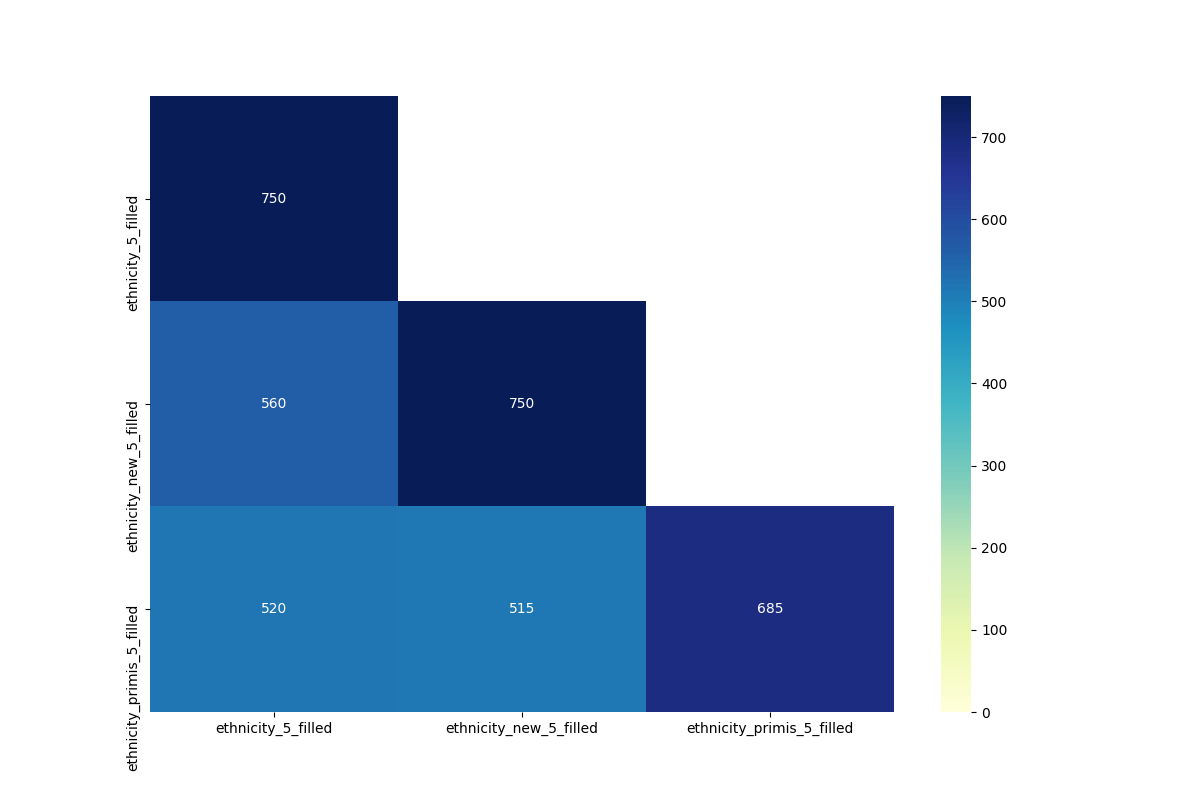

In [259]:
display(Image(f"../output/{output_path}/../figures/heatmap.png"))

### Latest vs. Most Common

In [260]:
for definition in definitions:
    df_sum = pd.read_csv(f'../output/{output_path}/simple_latest_common_{definition}.csv').set_index(definition)
    # sort rows by category index
    df_sum.columns = df_sum.columns.str.replace(definition + "_", "")
    df_sum.columns = df_sum.columns.str.lower()
    df_sum = df_sum.reindex(list(code_dict[definition].values()))
    
    df_counts = pd.DataFrame(
        np.diagonal(df_sum),
        index=df_sum.index,
     #   columns=[f"matching (n={np.diagonal(df_sum).sum()})"],
    )

    df_sum2 = df_sum.copy(deep=True)
    np.fill_diagonal(df_sum2.values, 0)
    df_diag = pd.DataFrame(
        df_sum2.sum(axis=1),
    )
    df_out = df_counts.merge(df_diag, right_index=True, left_index=True)
    columns=round(df_out.sum()/df_out.sum(axis=1).sum()*100,1)
    df_out.columns=[f"matching ({columns[0]}%)",f"not matching ({columns[1]}%)"]
    display(df_out)
    
    if code_dict != "":
        lowerlist = [x.lower() for x in (list(code_dict[definition].values()))]
        df_sum = df_sum[lowerlist]
    else:
        df_sum = df_sum.reindex(sorted(df_sum.columns), axis=1)

    # Combine count and percentage columns
    df_sum["population"]=df_sum.sum(axis = 1)
    for item in lowerlist:
        df_sum[item + "_pct"]= round(
                (df_sum[item].div(df_sum["population"])) * 100, 1
            )
    
        df_sum[item] = (
                df_sum[item].apply(lambda x: "{:,.0f}".format(x))
                + " ("
                + df_sum[item + "_pct"].astype(str)
                + ")"
            )
    df_sum = df_sum[lowerlist]

    display(df_sum)
    # df_expanded = pd.read_csv(f'../output/{output_path}/tables/latest_common_expanded_{definition}.csv').set_index(definition)
    
    # display(df_expanded)

,matching (97.7%),not matching (2.3%)
ethnicity_5,,
White,"15,659,180","120,390"
Mixed,"320,630","97,065"
Asian,"1,620,800","67,475"
Black,"554,270","50,015"
Other,"511,965","113,510"


,white,mixed,asian,black,other
ethnicity_5,,,,,
White,"15,659,180 (99.2)","33,375 (0.2)","22,815 (0.1)","16,445 (0.1)","47,755 (0.3)"
Mixed,"44,460 (10.6)","320,630 (76.8)","13,760 (3.3)","25,335 (6.1)","13,510 (3.2)"
Asian,"20,275 (1.2)","11,670 (0.7)","1,620,800 (96.0)","4,310 (0.3)","31,220 (1.8)"
Black,"18,725 (3.1)","19,555 (3.2)","4,120 (0.7)","554,270 (91.7)","7,615 (1.3)"
Other,"60,880 (9.7)","12,705 (2.0)","31,740 (5.1)","8,185 (1.3)","511,965 (81.9)"


,matching (97.9%),not matching (2.1%)
ethnicity_new_5,,
White,"15,503,455","109,315"
Mixed,"316,980","95,175"
Asian,"1,631,905","60,005"
Black,"548,760","47,935"
Other,"426,065","86,650"


,white,mixed,asian,black,other
ethnicity_new_5,,,,,
White,"15,503,455 (99.3)","32,815 (0.2)","23,000 (0.1)","16,350 (0.1)","37,150 (0.2)"
Mixed,"44,685 (10.8)","316,980 (76.9)","14,240 (3.5)","25,515 (6.2)","10,735 (2.6)"
Asian,"20,615 (1.2)","11,870 (0.7)","1,631,905 (96.5)","4,320 (0.3)","23,200 (1.4)"
Black,"18,615 (3.1)","19,035 (3.2)","4,140 (0.7)","548,760 (92.0)","6,145 (1.0)"
Other,"48,330 (9.4)","9,780 (1.9)","21,970 (4.3)","6,570 (1.3)","426,065 (83.1)"


,matching (98.0%),not matching (2.0%)
ethnicity_primis_5,,
White,"12,072,865","85,855"
Mixed,"299,275","70,205"
Asian,"1,417,270","43,515"
Black,"436,625","35,915"
Other,"424,800","67,310"


,white,mixed,asian,black,other
ethnicity_primis_5,,,,,
White,"12,072,865 (99.3)","25,145 (0.2)","17,615 (0.1)","11,510 (0.1)","31,585 (0.3)"
Mixed,"32,680 (8.8)","299,275 (81.0)","10,740 (2.9)","17,655 (4.8)","9,130 (2.5)"
Asian,"16,195 (1.1)","8,765 (0.6)","1,417,270 (97.0)","2,555 (0.2)","16,000 (1.1)"
Black,"13,555 (2.9)","15,015 (3.2)","2,620 (0.6)","436,625 (92.4)","4,725 (1.0)"
Other,"35,500 (7.2)","8,725 (1.8)","17,960 (3.6)","5,125 (1.0)","424,800 (86.3)"


### State Change

In [281]:
for definition in definitions:
    df_state_change = pd.read_csv(f'../output/{output_path}/simple_state_change_{definition}.csv').set_index(definition)
    df_state_change.columns = df_state_change.columns.str.replace(definition + "_", "")
    #resort rows
    df_state_change = df_state_change.reindex(list(code_dict[definition].values()))
    df_state_change = df_state_change.reset_index()
    
    df_state_change[definition]=df_state_change[definition]+": " +df_state_change["n"].apply(lambda x: "{:,.0f}".format(x))
    df_state_change = df_state_change.set_index(definition)
    df_state_change=df_state_change[lowerlist]
    display(df_state_change)

,white,mixed,asian,black,other
ethnicity_5,,,,,
"White: 15,688,375","15,688,375","58,750","30,130","24,200","96,430"
"Mixed: 351,745","58,850","351,745","17,010","32,020","18,745"
"Asian: 1,635,560","39,635","23,720","1,635,560","8,225","53,160"
"Black: 566,150","31,120","38,855","6,340","566,150","13,445"
"Other: 548,975","72,775","20,210","43,470","11,030","548,975"


,white,mixed,asian,black,other
ethnicity_new_5,,,,,
"White: 15,527,840","15,527,840","58,125","30,205","23,900","76,290"
"Mixed: 347,180","58,265","347,180","17,245","31,710","14,685"
"Asian: 1,643,485","40,075","24,225","1,643,485","8,220","38,145"
"Black: 559,260","30,785","38,555","6,310","559,260","10,750"
"Other: 453,150","56,425","15,170","30,005","8,665","453,150"


,white,mixed,asian,black,other
ethnicity_primis_5,,,,,
"White: 12,089,635","12,089,635","39,135","22,110","15,390","55,195"
"Mixed: 318,515","41,310","318,515","12,655","21,205","11,615"
"Asian: 1,424,905","28,425","15,625","1,424,905","4,200","24,390"
"Black: 443,960","19,815","25,325","3,815","443,960","7,415"
"Other: 443,930","41,500","12,500","23,345","6,595","443,930"
